<a href="https://colab.research.google.com/github/usher233/GraduationThesis/blob/step-1-data-preparation/Codev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import keras
import tensorflow as tf

from keras.utils import normalize


In [3]:
TRAIN_DATA_DIR = "/content/drive/MyDrive/Graduation_thesis/Dataset/images"
IMG_SIZE = 128


In [108]:
#img_test = cv2.imread("/content/drive/MyDrive/Graduation_thesis/Dataset/mask/id_1.png")
#img_test = cv2.resize(img_test,(IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_NEAREST)
#img_test = np.array(img_test)

In [109]:
#check RGB values
np.unique(img_test)

array([  0, 127, 128, 255], dtype=uint8)

In [135]:
train_images = []
image_names = glob.glob("/content/drive/MyDrive/Graduation_thesis/Dataset/images/*.png")
image_names.sort()  #Make sure the loaded images are in order
#print(image_names)
for image in image_names:
  img = cv2.imread(image, 1)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)   #resize the images to IMG_SIZE
  #print(image)
  train_images.append(img)
train_images = np.array(train_images)

In [22]:
train_images.shape

(640, 128, 128, 3)

In [119]:
train_masks = []
mask_names = glob.glob("/content/drive/MyDrive/Graduation_thesis/Dataset/mask/*.png")
mask_names.sort()
#print(mask_names)
for mask in mask_names:
  masks = cv2.imread(mask,1)
  masks = cv2.resize(masks,(IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)
  masks = cv2.cvtColor(masks, cv2.COLOR_RGB2BGR)
  #print(mask)
  train_masks.append(masks)
train_masks = np.array(train_masks)

In [120]:
train_masks.shape

(640, 128, 128, 3)

In [121]:
np.unique(train_masks[0])

array([  0, 127, 128, 255], dtype=uint8)

In [126]:
#mask labels
Background = [127,255,255]
Wheat = [128,0,0]
Soil = [0, 0, 0]

In [127]:
print(Background,Wheat,Soil)

[127, 255, 255] [128, 0, 0] [0, 0, 0]


In [128]:
def rgb_to_2D_label(label):
    """
    Supply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Background,axis=-1)] = 0
    label_seg [np.all(label==Wheat,axis=-1)] = 1
    label_seg [np.all(label==Soil,axis=-1)] = 2
    
    label_seg = label_seg[:,:,1]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(train_masks.shape[0]):
    label = rgb_to_2D_label(train_masks[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2]


In [132]:
print(np.count_nonzero(labels[0] == 0))
print(np.count_nonzero(labels[0] == 1))
print(np.count_nonzero(labels[0] == 2))

5273
8904
2207


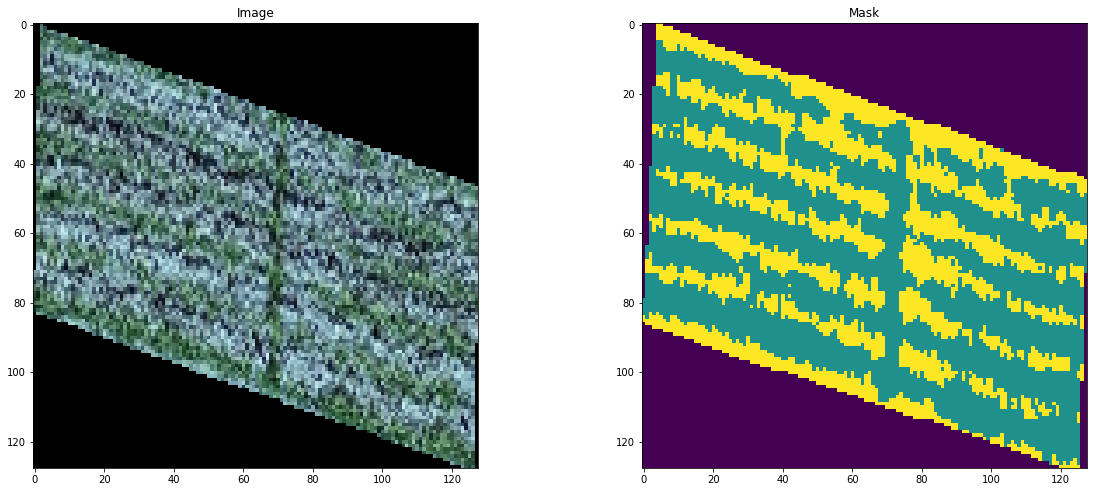

In [144]:
#check the dataset is right!!!!!!!
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[257]
mask = labels[257][:,:,0]
plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [ ]:
X = image_dataset
Y = mask_dataset
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
import segmentation_models as sm
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 40
n_classes = 3
activation = 'softmax'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [ ]:
#preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)

44113920/44107200 [==============================] - 2s 0us/step


In [ ]:
optim = keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)

In [ ]:
history=model.fit( x_train,
          y_train,
          batch_size=8,
          epochs=10,
          verbose=1,
          validation_data=(x_val,y_val))

Train on 512 samples, validate on 128 samples
Epoch 1/10
512/512 [==============================] - 864s 2s/step - loss: 9.6531 - iou_score: 0.1824 - f1-score: 0.2375 - val_loss: 12.8175 - val_iou_score: 0.3726 - val_f1-score: 0.4349
Epoch 2/10
512/512 [==============================] - 825s 2s/step - loss: 8.2086 - iou_score: 0.4007 - f1-score: 0.3628 - val_loss: 8.2922 - val_iou_score: 0.5126 - val_f1-score: 0.4128
Epoch 3/10
512/512 [==============================] - 827s 2s/step - loss: 7.9571 - iou_score: 0.4588 - f1-score: 0.3848 - val_loss: 8.0247 - val_iou_score: 0.4981 - val_f1-score: 0.3984
Epoch 4/10
512/512 [==============================] - 808s 2s/step - loss: 7.8662 - iou_score: 0.4699 - f1-score: 0.3884 - val_loss: 7.8745 - val_iou_score: 0.4908 - val_f1-score: 0.3956
Epoch 5/10
512/512 [==============================] - 803s 2s/step - loss: 7.8246 - iou_score: 0.4753 - f1-score: 0.3901 - val_loss: 7.8394 - val_iou_score: 0.4852 - val_f1-score: 0.3937
Epoch 6/10
512/512

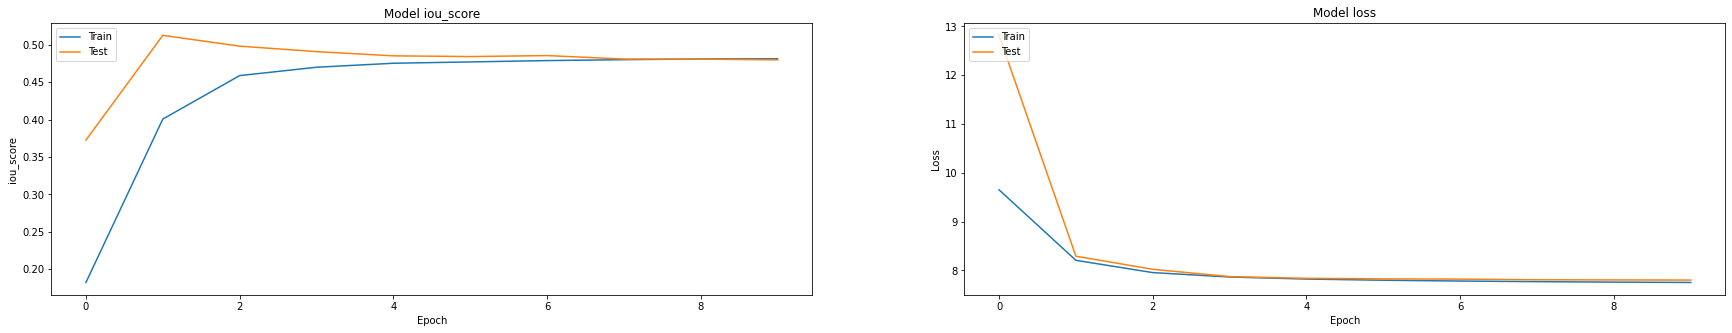

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('firstmodel.h5')

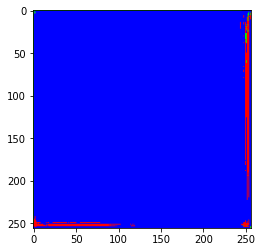

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Graduation_thesis/Dataset/train_tif_final/id_1.tif')       
test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))

test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)

In [ ]:
from keras.utils import normalize
image_dataset = np.expand_dims(image_dataset, axis=3)
image_dataset = normalize(image_dataset, axis=1)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
X = image_dataset
Y = mask_dataset

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
#preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
model = keras.models.load_model('firstmodel.h5', compile=False)

In [ ]:
model.compile(optim, total_loss, metrics)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
history=model.fit( x_train,
          y_train,
          batch_size=8,
          epochs=40,
          verbose=1,
          callbacks=callbacks,
          validation_data=(x_val,y_val))

ValueError: ignored

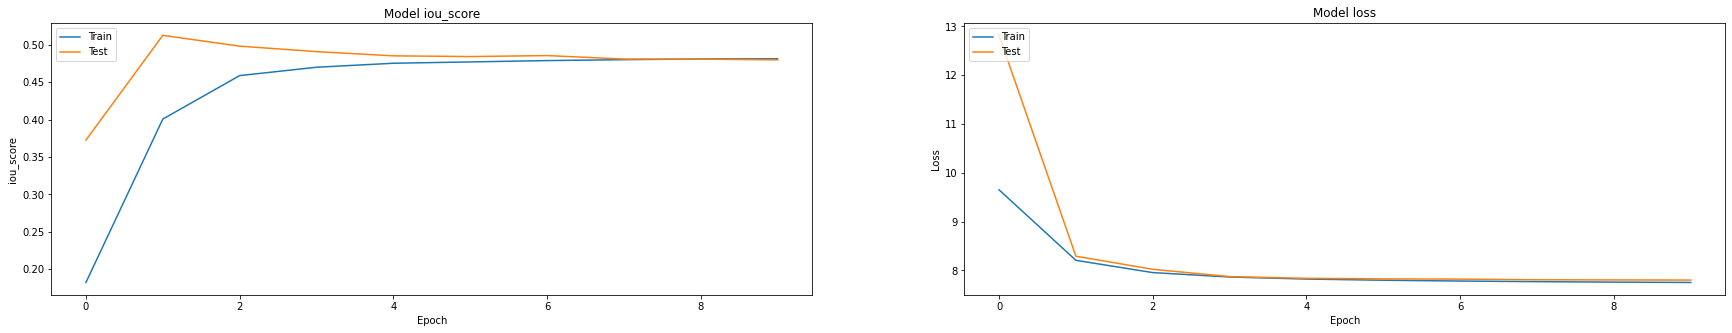

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

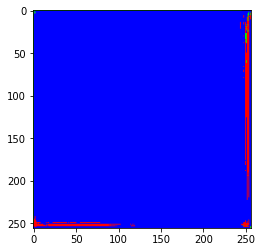

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Graduation_thesis/Dataset/train_tif_final/id_1.tif')       
test_img = cv2.resize(test_img, (IMG_SIZE, IMG_SIZE))

test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)